This note replicates the results in *Chen, Kaiji, Ayşe İmrohoroğlu, and Selahattin İmrohoroğlu (2006). The Japanese Saving Rate, American Economic Review, Vol. 96, Issue 5, 1850-1858.* 

## Model



A typical neo-classical growth model. For detail see paper.

## Data

In [1]:
file = 'data/JapanSavingRate/datafile.txt'
cols = ['year', 
        'gamma', # growth rate of TFP factor
        'pop',   # population growth rate
        'gov',   # government spending share
        'hh',    # hours input
        'ee',    # employment rate
        'delta', # depreciation rate
        'tau',   # capital income tax
        'jsrate' # actual Japanese net national saving rate
       ]
df = pd.read_csv(file, sep='\t', header=None, names=cols)
n_years = len(df)

## Calibration and Computation

The computational strategy
- "start from actual Japanese capital-output ratio in 1956 and use a shooting algorithm to numerically compute the equilibrium transition path of the macroeconomic aggregates generated by the model as it converges to a final steady state"
- "To do this, first we obtain the equilibrium conditions for the economy and detrend them. The detrended steady-state saving rate, ... $\tilde{s}=\frac{(\gamma n-1) \tilde{k}}{\tilde{y}-\tilde{\delta} \tilde{k}}$ , and time-varying saving rates ... are given by, $s_{t}=\frac{Y_{t}-G_{t}-C_{t}-\delta_{t} K_{t}}{Y_{t}-\delta_{t} K_{t}}$"

4 parameters are time invariant: 
- capital share of output $\theta$ = 0.363 = sample average of GNP share of capital over 1956-2000
- subjective time discount factor $\beta$ = 0.96327 so that capital-output ratio is 2 at steady state
- total discretionary hours in a week $T$ = 105
- share of leisure in the utility function $\alpha$ = 1.45 to obtain an average labor input of 44 to match average aggregate hours in data 
- (Aggregate labor input is the product of average weekly hours worked and the employment rate, where the latter is taken as the ratio of total number of employed workers and working-age population.)

In our benchmark simulation, we use the actual time series data between 1956-2000 for the exogenous variables. For computation of steady state, we set exogenous variables equal to their sample average.
- TFP growth rate
- population growth rate
- depreciation rate
- share of government purchases in GNP
- capital income tax rate

implements the shooting algorithm used in Hayashi and Prescott (The structure of the shooting algorithm is nicely summarized in Judd (1998), pp. 355-357. )
- $c_t$, $h_t$, and $k_{t+1}$ for $t>=0$ are endogenous variables obtained by using the equilibrium conditions of the model.
- $k_0$ is a given initial condition
- $c_0$ is a guess, the subject of shooting
- $h_0$ is given by fvalue_ini2.m
- $k_{t+1}$ (for $t>=0$) is given by lines 142 and 143 in the main code
- $c_t$ and $h_t$ (for $t>=1$) are given by fvalue2.m

In [2]:
# 4 invariant parameters
theta   = 0.363        # share of capital in production function
beta    = 0.96327      # utility discount factor     
T       = 105          # total discretionary hours in a week
alpha   = 1.45         # parameter for disutility of labor


# model parameters at the steady state 
# i.e. set exogenous variables equal to their sample average

gamma_ss  = 1.0315     # steady state TFP factor growth rate (corresponds to 2% TFP growth rate)
pop_ss    = 1.011976   # steady state value of growth rate of time endowment
delta_ss  = 0.10       # depreciation rate for physical capital at the steady state
gov_ss    = 0.14       # share of government spending in GNP at the steady state
tau_ss    = 0.35       # capital income tax rate at the steady state
labor     = 31.82      # exogenous labor input average over this time period


# #When feeding in steady state numbers use these:
# gamma   = np.array([gamma_ss]*n_years)
# pop     = np.array([pop_ss]*n_years)
# delta   = np.array([delta_ss]*n_years)
# tau     = np.array([tau_ss]*n_years)
# gov     = np.array([gov_ss]*n_years)
# he      = np.array([labor]*n_years)


In [3]:
# Steady state values

kh_ss = (
    (gamma_ss - beta + delta_ss * beta * (1 - tau_ss)) / (beta * (1 - tau_ss) * theta)
) ** (1 / (theta - 1))
ch_ss = (1 - gov_ss) * kh_ss ** theta - kh_ss * (gamma_ss * pop_ss + delta_ss - 1)
h_ss = T / (1 + alpha * ch_ss / ((1 - theta) * kh_ss ** theta))
c_ss = ch_ss * h_ss
k_ss = kh_ss * h_ss
y_ss = k_ss ** theta * h_ss ** (1 - theta)
save_ss = k_ss * (gamma_ss * pop_ss - 1) / (y_ss - delta_ss * k_ss)  # saving rate in ss
ky_ss = k_ss / y_ss  # capital-output ratio in ss

In [4]:
def fvalue_ini2(h, c, alpha, theta, k, T):
    # labor leisure choice
    y=T-alpha*c/((1-theta)*(k/h)**theta)-h
    return y

def fvalue2(x, c, gamma_t, beta, tau_t, theta, delta_t, alpha, kprime,T):
    cprime=x[0]
    hprime=x[1]

    # Euler equation
    y_c= c/gamma_t*beta*(1+(1-tau_t)*(theta*(kprime/hprime)**(theta-1)-delta_t))-cprime

    # labor leisure choice
    y_h= T-alpha*cprime/((1-theta)*(kprime/hprime)**theta)-hprime

    y=[y_c, y_h]
    return y

In [157]:
# parameters related to shooting algorithm

N = 2000;        # length of period used for forward shooting algorithm
epsilon = 1e-3;  # convegence criteria for shooting algorithm 
transp = 99;    # number of periods until convergence to the steady-state

In [158]:
# Generating exogenous values for year beyond 2001

year = np.r_[df.year.values, range(2001, N-n_years+2001)]
gamma = np.r_[df.gamma.values, [gamma_ss]*(N-n_years)]
tau = np.r_[df.tau.values, [tau_ss]*(N-n_years)]
delta = np.r_[df.delta.values, [delta_ss]*(N-n_years)]
pop = np.r_[df['pop'].values, [pop_ss]*(N-n_years)]
gov = np.r_[df.gov.values, [gov_ss]*(N-n_years)]

In [159]:
# Calculation of transition path, using forward shooting algorithm
c_L = c_ss*0.0;            # initial guess for lower bound for consumption
c_H = c_ss*1.2;            # initial guess for upper bound for consumption

# Setting initial capital stock
ky_ini  = 1.37; # k/y ratio at 1956
k0      = ky_ini**(1/(1-theta))*45.5;  # inital capital stock so that capital output ratio equal to data in 1956

y       = 0                         # dummy variable for convergence
lc      = 0                         # dummy for time
max_search = 100

In [160]:
while (y != 3) & (lc < max_search):
    y = 0

    # initialize sequences to be calculated to zero
    kk = np.zeros(N,)
    cc = np.zeros(N,)
    kkgg = np.zeros(N,)
    ccgg = np.zeros(N,)
    he = np.zeros(N,)

    kk[0] = k0

    t = 0
    lc = lc + 1

    # update guess for consumption at initial period
    cc[0] = (c_L + c_H) / 2

    c0 = cc[0]

    # initial guess for h0
    X1 = 50.7

    # solve for h0, given k0 and c0
    h0 = sp.optimize.fsolve(fvalue_ini2, X1, args=(c0, alpha, theta, k0, T))

    he[0] = h0

    # start shooting
    while t < N-1:
        t = t + 1
        kk[t] = (
            (1 - delta[t - 1]) * kk[t - 1]
            + (1 - gov[t - 1]) * (kk[t - 1] ** theta * he[t - 1] ** (1 - theta))
            - cc[t - 1]
        ) / (gamma[t - 1] * pop[t - 1])
        if kk[t] < 0:
            print(f'kk is negative at period {t}', end=' -> ')
            y = 1
            break
        elif not np.isreal(kk[t]):
            print(f'kk is imaginary at period {t}', end=' -> ')
            y = 1
            break

        # initial guess for c2
        X0 = [cc[t - 1], he[t - 1]]

        # solve for optimal c and h for tomorrow
        X2 = sp.optimize.fsolve(fvalue2,X0,args=(
                cc[t - 1],gamma[t - 1],beta,tau[t],theta,delta[t],alpha,kk[t],T,),
                       )
#         X2 = res.x
#         if not res.success:
#             print('error in solve optimal c and h for tomorrow: fail to find root')

                
        cc[t] = X2[0]
        he[t] = X2[1]

        cgrow = cc[t] / cc[t-1]
        kgrow = kk[t] / kk[t-1]
        ccgg[t-1] = cgrow
        kkgg[t-1] = kgrow
        
        if (cgrow <=1) & (t>transp):
            y=2
            print(f'consumption does not grow at period {t}', end=' -> ')
            break
        elif (kgrow <=1) & (t>transp):
            y=1
            print(f'capital does not grow at period {t}', end=' -> ')
            break

    # check convergence and update c_L (or c_H)
    if (abs(cc[t]-c_ss) < epsilon) & (abs(kk[t]-k_ss) < epsilon*10):
        y=3
        print(f'Converged at period {t}')
        break
    elif y==2:
        c_L = cc[0]
        print('c_L inc_reased')
    elif y==1:
        c_H = cc[0];
        print('c_H lowered');
    else:
        print(f'number of iterations exceeded without convergence N and t are {N}, {t}')
        break

if lc >= max_search:
    print('Converge Failed')

consumption does not grow at period 100 -> c_L inc_reased
kk is negative at period 8 -> c_H lowered
consumption does not grow at period 100 -> c_L inc_reased
consumption does not grow at period 100 -> c_L inc_reased
kk is negative at period 13 -> c_H lowered
consumption does not grow at period 100 -> c_L inc_reased
kk is negative at period 22 -> c_H lowered
consumption does not grow at period 100 -> c_L inc_reased
consumption does not grow at period 100 -> c_L inc_reased
kk is negative at period 34 -> c_H lowered
consumption does not grow at period 100 -> c_L inc_reased
consumption does not grow at period 100 -> c_L inc_reased
consumption does not grow at period 100 -> c_L inc_reased
kk is negative at period 48 -> c_H lowered
consumption does not grow at period 100 -> c_L inc_reased
consumption does not grow at period 100 -> c_L inc_reased
consumption does not grow at period 100 -> c_L inc_reased
kk is negative at period 59 -> c_H lowered
consumption does not grow at period 100 -> c_L 

/Users/alalalalaki/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/alalalalaki/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


 -> c_L inc_reased
kk is negative at period 95 -> c_H lowered
consumption does not grow at period 100 -> c_L inc_reased
kk is negative at period 99 -> c_H lowered
capital does not grow at period 100 -> c_H lowered
capital does not grow at period 100 -> c_H lowered
consumption does not grow at period 100 -> c_L inc_reased
consumption does not grow at period 100 -> c_L inc_reased
consumption does not grow at period 100 -> c_L inc_reased
consumption does not grow at period 100 -> c_L inc_reased
capital does not grow at period 100 -> c_H lowered
consumption does not grow at period 100 -> c_L inc_reased
consumption does not grow at period 100 -> c_L inc_reased
capital does not grow at period 100 -> c_H lowered
consumption does not grow at period 100 -> c_L inc_reased
capital does not grow at period 100 -> c_H lowered
consumption does not grow at period 100 -> Converged at period 100


In [164]:
# calculating values in the model
N = t+1
kk=kk[:N]
he=he[:N]
delta=delta[:N]
cc=cc[:N]
gov=gov[:N]
tau=tau[:N]

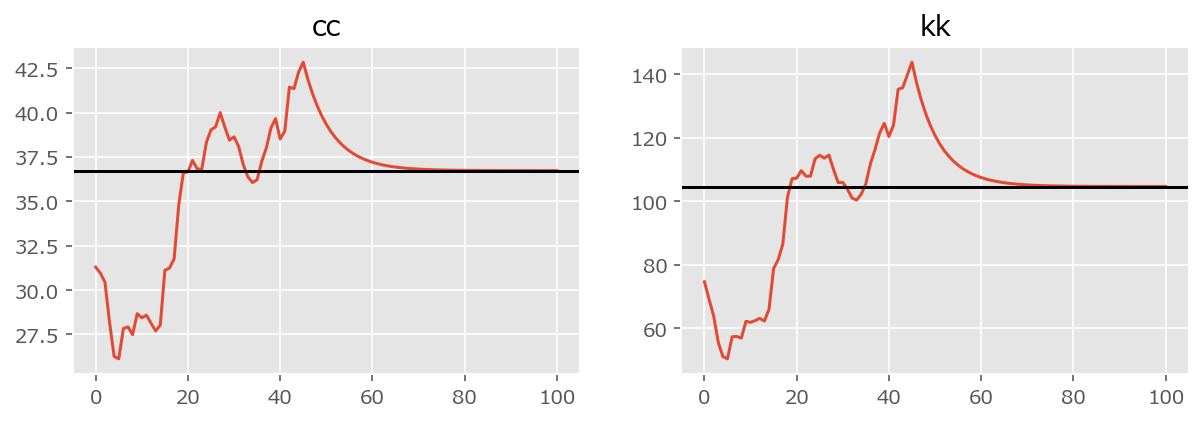

In [165]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(cc,); ax[0].set_title('cc'); ax[0].axhline(c_ss, c='black');
ax[1].plot(kk,); ax[1].set_title('kk'); ax[1].axhline(k_ss, c='black');

In [166]:
yy      = kk**theta*he**(1-theta)               # GNP
rr      = (yy*theta/kk)-delta                   # rate of return for capital
rr      = rr*(1-tau)                            # after tax rate of return
savrate = (yy*(1-gov)-cc-kk*delta)/(yy-kk*delta) # saving rate
ky      = kk/yy                                 # capital output ratio

In [169]:
# save results
result1 = pd.DataFrame({'year':year[:N],'k':kk, 'c':cc, 'y':yy,
                        'ky':ky, 'r':rr, 'he':he, 'saverate':savrate})

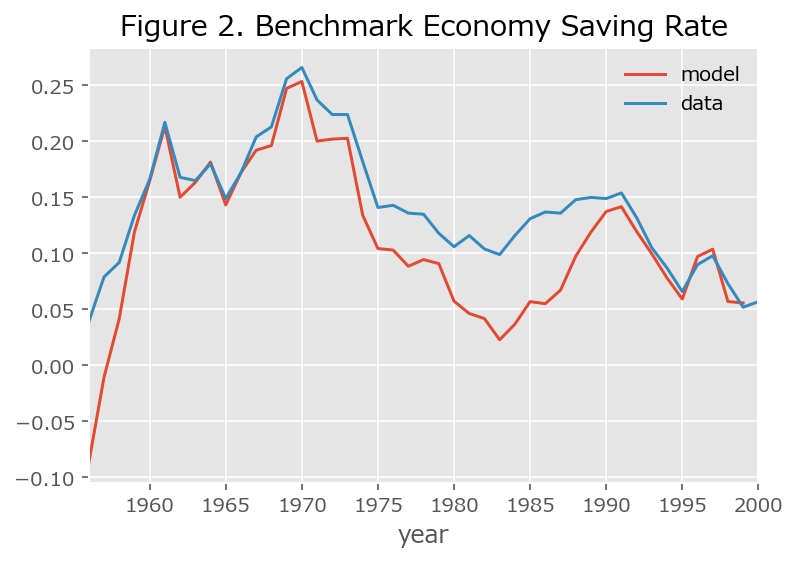

In [170]:
fig,ax=plt.subplots()
result1[:44].plot('year','saverate', label='model', ax=ax)
df.plot('year', 'jsrate', label='data', ax=ax)
ax.set_title('Figure 2. Benchmark Economy Saving Rate')
plt.show();